## 9.3 Modern convnet architecture patterns

In [1]:
import sys, os, shutil, pathlib

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo

import tensorflow as tf

In [5]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')  # 'My Drive' is the default name of Google Drives
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/7-advanced-DL-best-practices')
    os.listdir()

---

## 9.3.2 Residual connections

<!-- ![Chollet residual](images/chollet.residual.png) -->
<img src="https://drive.google.com/uc?id=1SELDBXb0QGUzSrkgylyKjFy916PKEOss">

<small>DLWP, p.252</small>

Residual connections address two problems:
1. Information bottlenecks;
2. Vanishing gradients.

### 1. Information bottlenecks

The representational power of a layer is limited by its size: information can get lost in the processing pipeline. 

*For example, high frequency information can never be recovered by later layers if there is a low pass filter early on.*

Residual connections re-inject the information content of earlier layer outputs.

### 2. Vanishing gradients 

During backpropagation, we apply the **chain rule**, as we have seen, which means that we multiply the gradients of each node in our network.

As we saw in the case of RNNs, multiplying either small numbers will make them smaller!

#### Note

The LSTM **carry** (memory) propagates information forward in time and helps avoid vanishing gradients in recurrent networks. The residual connection has a similar effect! 

Suppose layer 1 is the top layer, layer 2 is the first hidden layer from the top etc, the gradient of the loss with respect to a weight in layer 8 is:

$
\frac{df_{loss}}{dW_{8}} = \frac{df_{loss}}{dL_{layer 1}}\frac{df_{layer 1}}{dL_{layer 2}}\frac{dL_{layer 2}}{dL_{layer 3}}\frac{dL_{layer 3}}{dL_{layer 4}}\ldots\frac{dL_{layer 8}}{dW_8}
$

A product of layer gradients $\frac{dL_i}{dL_{i+1}}$.

The combined product can get **very small** if the layer gradients have an absolute value less than 1.

### Learn the change


A consequence of all this is that it incentivises the network to learn the **difference** between the previous step and the new one.

Indeed, the transformed representation will be re-added to its input: what is encoded by the layer is **how the input should change**.

**Residual block where the number of filters changes**

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(inputs)

residual = x                                                            # 1. save the current state of x (residual)

                                                   # ↓ keep dimensions the same!
x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x) # 2.a the first branch
                                                                        

residual = tf.keras.layers.Conv2D(64, 1)(residual)                      # 2.b the second branch
                                                                        # (transform residual with Conv2D and 
                                                                        # just 1 filter so that the shapes work)

x = tf.keras.layers.add([x, residual])                                  #  reinject past x

**Case where target block includes a max pooling layer**

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(inputs)

residual = x                                                            # 1. save the current state of x (residual)                                      

                                                 # ↓ keep dimensions the same!
x = tf.keras.layers.Conv2D(64, 3,activation="relu", padding="same")(x) # 2.a the first branch
                                  # ↓ also with MaxPooling (rare)
x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)

residual = tf.keras.layers.Conv2D(64, 1, strides=2)(residual)           # 2.b the second branch
                                                                        # (transform residual with Conv2D and 
                                                                        # just 1 filter so that the shapes work)

x = tf.keras.layers.add([x, residual]) # merging current and residual

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x                                                                 # ← SAVE
    x = tf.keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x) #   branch 1
    x = tf.keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)       #   branch 2
    elif filters != residual.shape[-1]:
        residual = tf.keras.layers.Conv2D(filters, 1)(residual)                  #   branch 2
    x = tf.keras.layers.add([x, residual])                                       # ← REINJECT
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d_6[0][0]']               
                                                                                              

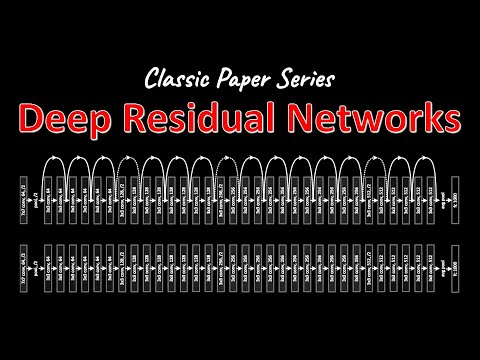

In [2]:
YouTubeVideo('GWt6Fu05voI', width=853, height=480) # Yannic Kilcher, [Classic] Deep Residual Learning for Image Recognition (Paper Explained) 

---

## 9.3.3 Batch normalization

The output from a layer might have some large values – and these will dominate training.

Batch normalisation is **like data preprocessing** at the level of a hidden layer.

Normalise layer output to keep unusually high/low values under control.

It assists the optimiser and allows deeper networks (**stabilising** training).

Some very deep networks would be impossible to train without batch normalisation.

#### Note

Behaviour during inference (when *using* the trained model):

*"During training, it uses the **mean and variance of the current batch of data** to normalize samples, and during inference (when a big enough batch of representative data may not be available), it uses **an exponential moving average of the batch-wise mean and variance of the data** seen during training."* (DLWP, p.255, my emphasis)

#### Note

There is a debate around placing `BatchNorm` before or after activations (Chollet advocates: before).

**How not to use batch normalization:**

```python
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
```

**How to use batch normalization (the activation comes last):**

```python
x = tf.keras.layers.Conv2D(32, 3, use_bias=False)(x) # no activation
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x) # activation after normalisation
```

<!-- ![Chollet batch norm](images/chollet.batch-norm-fine-tuning.p.257.png) -->
<img src="https://drive.google.com/uc?id=1jE8-q1M4kWOusgJamn_yYBlVLEPWWU01">

<small>DLWP, p.257</small>

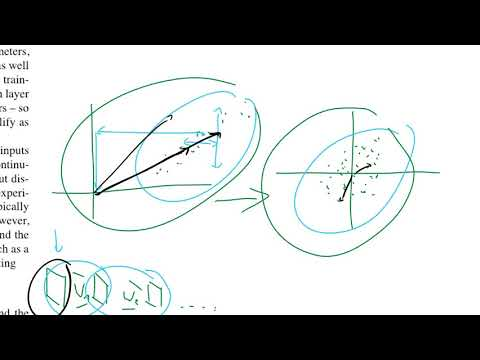

In [3]:
YouTubeVideo('OioFONrSETc', width=853, height=480) # Yannic Kilcher, Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift 

### Batch norm vs Layer norm

Batch norm computes the statistics over a **batch of data**, which statisticians hate, and creates difficulties (train/inference).

There have been several attempts to replace it. One of them is **layer norm** (used in the Transformer).

The statistics are calculated on the *output of a layer*.

```python
# input shape: (batch_size,sequence_length, embedding_dim)
def layer_normalization(batch_of_sequences):
                             # pool data over the last axis ↓--┐
    mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)#↓ 
    variance = np.var(batch_of_sequences, keepdims=True, axis=-1)
    return (batch_of_sequences - mean) / variance
```

```python
# input shape: (batch_size, height, width, channels)
def batch_normalization(batch_of_images):              # ↓ pool data over the
    mean = np.mean(batch_of_images, keepdims=True, axis=(0, 1, 2))    
    variance = np.var(batch_of_images, keepdims=True, axis=(0, 1, 2)) 
    # (that creates interactions between samples!)        # ↑ batch & w/h axes

```

<img src="images/types-of-normalisations.png">
<img src="https://drive.google.com/uc?id=1Rna9Gc88YZqdIlSX2JP3y86w3bzGjBWJ">


<small>["Batch normalization vs layer normalization", Stack Overflow](https://stackoverflow.com/a/71397384)</small>  
<small>[Yuxin Wu, Kaiming He, "Group Normalization", arxiv](https://arxiv.org/abs/1803.08494)</small>

> Unlike batch normalization, Layer Normalization directly estimates the normalization statistics **from the summed inputs to the neurons within a hidden layer** so the normalization **does not introduce any new dependencies between training cases**. It works well for RNNs and improves both the training time and the generalization performance of several existing RNN models. More recently, it has been used with Transformer models. (My emphasis)

[Ba et al., "Layer Normalization", Papers with Code](https://paperswithcode.com/method/layer-normalization)

This passage in the next video explains layer normalisation alongside batch and group normalisation:

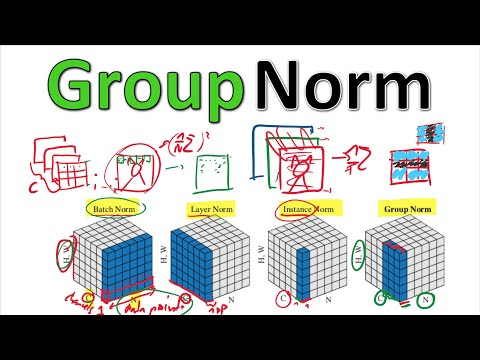

In [12]:
YouTubeVideo('l_3zj6HeWUE', width=853, height=480, start=542) # Yannic Kilcher,  Group Normalization (Paper Explained) 

---

## 9.3.4 Depthwise separable convolutions

A replacement for `Conv2D` that is:

- lighter (fewer trainable weights);
- comparable in performance.

The idea is to use a spatial convolution on each channel under the assumption that:

- spatial locations are highly correlated;
- different channels are fairly independent.

The parallel convolutions are mixed via a pointwise (1D) convolution layer.

Depthwise seperable convolutions are the basis of the high-performing **Xception** architecture.

### Normal convolution

One filter: the filter has the same depth as the feature map it is applied to (here: 3 channels).

<img src="https://drive.google.com/uc?id=1se-_IDxhhy8SISfQ7tz4XnWd-nEkEjQr">
<!-- <img src="images/depthwise/other/depthwise.1.png"> -->

<small>Source: [Chi-Feng Wang, "A Basic Introduction to Separable Convolutions", Medium](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)</small>

### Normal convolution

Multiple fitlers: do the same operation several times, leading to numerous output feature maps.

<img src="https://drive.google.com/uc?id=1bFbDf7vvanwFEdCnoP-SdRwg9L2zejt1">
<!-- <img src="images/depthwise/other/depthwise.2.png"> -->

<small>Source: [Chi-Feng Wang, "A Basic Introduction to Separable Convolutions", Medium](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)</small>

### Normal convolution

(Same as one filter picture above, just vertically.)

<img src="https://drive.google.com/uc?id=13OmO71BCTSpvF13rHB-d9ykSpud54kbj">
<!-- ![Normal Convolution](images/depthwise/normal-convolution.png) -->

<small>Source: [Atul Pandey, "Depth-wise Convolution and Depth-wise Separable Convolution", Medium](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)</small>

<img src="https://drive.google.com/uc?id=1v6gr-IQlo55NVr1xr0fFxR9Fjl2jO7wD">
<!-- ![Normal Convolution](images/depthwise/depthwise.1.png) -->

<small>Source: [Atul Pandey, "Depth-wise Convolution and Depth-wise Separable Convolution", Medium](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)</small>

<img style="height:750px" src="https://drive.google.com/uc?id=1angIlXvRf3TwbT4956CMaNPaPJGJA7Qx">
<!-- ![Normal Convolution](images/depthwise/depthwise.2.png) -->

<small>Source: [Atul Pandey, "Depth-wise Convolution and Depth-wise Separable Convolution", Medium](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)</small>

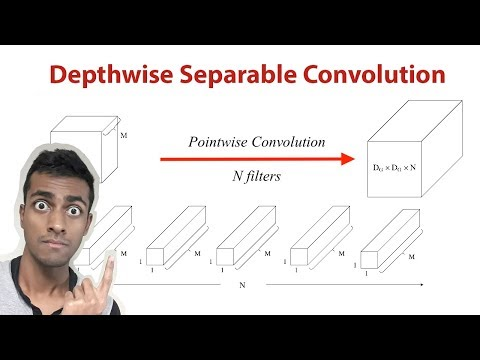

In [3]:
YouTubeVideo('T7o3xvJLuHk', width=853, height=480) # Depthwise Separable Convolution - A FASTER CONVOLUTION!

---

## 9.3.5 Putting it together: A mini Xception-like model

An example of a model using these techniques: `BatchNormalization` and `SeparableConv2D`!

In Colab there is a `kaggle` command available (you need an account), otherwsie manually download the data from https://www.kaggle.com/c/dogs-vs-cats/.


```python
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq train.zip
```

In [15]:
original_dir = pathlib.Path("cats-vs-dogs")
train_dir = original_dir / "train"
new_base_dir = original_dir / pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        small_dir = new_base_dir / subset_name / category # sweet Pathlib syntax
        if not os.path.isdir(small_dir) and len(os.listdir(small_dir) == end_index - start_index):
            os.makedirs(small_dir, exist_ok=True)
            fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
            for fname in fnames:
                shutil.copyfile(src=train_dir / fname,
                                dst=small_dir / fname)
        else:
            print(f"found {small_dir}, done.")

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

batch_size = 32
train_dataset = tf.keras.utils.image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

found cats-vs-dogs/cats_vs_dogs_small/train/cat, done.
found cats-vs-dogs/cats_vs_dogs_small/train/dog, done.
found cats-vs-dogs/cats_vs_dogs_small/validation/cat, done.
found cats-vs-dogs/cats_vs_dogs_small/validation/dog, done.
found cats-vs-dogs/cats_vs_dogs_small/test/cat, done.
found cats-vs-dogs/cats_vs_dogs_small/test/dog, done.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [16]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

In [5]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = tf.keras.layers.Rescaling(1./255)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x                                                                    # ← RESIDUAL

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # ← SEPARABLE CONV

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # ← SEPARABLE CONV

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = tf.keras.layers.Conv2D(                                              # reshape the residual
        size, 1, strides=2, padding="same", use_bias=False
    )(residual)
    x = tf.keras.layers.add([x, residual])                                          # ← REINJECTED

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [8]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset
)

Epoch 1/100
63/63 [==============================] - 30s 471ms/step - loss: 0.6695 - accuracy: 0.5885 - val_loss: 0.6992 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 30s 476ms/step - loss: 0.6434 - accuracy: 0.6240 - val_loss: 0.6983 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 30s 482ms/step - loss: 0.6242 - accuracy: 0.6500 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 30s 469ms/step - loss: 0.6152 - accuracy: 0.6575 - val_loss: 0.7031 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 30s 471ms/step - loss: 0.5834 - accuracy: 0.7015 - val_loss: 0.6874 - val_accuracy: 0.5530
Epoch 6/100
63/63 [==============================] - 30s 473ms/step - loss: 0.5831 - accuracy: 0.6935 - val_loss: 0.9230 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 31s 485ms/step - loss: 0.5382 - accuracy: 0.7330 - val_loss: 0.9767 - val_accuracy:

In [9]:
def plot_history(history):

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    fig, axs = plt.subplots(nrows=1,ncols=2, constrained_layout=True, figsize=(10,3))

    axs[0].plot(epochs, accuracy, "bo", label="Training accuracy")
    axs[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
    axs[0].set_title("Training and validation accuracy")
    axs[0].legend()

    axs[1].plot(epochs, loss, "bo", label="Training loss")
    axs[1].plot(epochs, val_loss, "b", label="Validation loss")
    axs[1].set_title("Training and validation loss")
    axs[1].legend()
    plt.show()

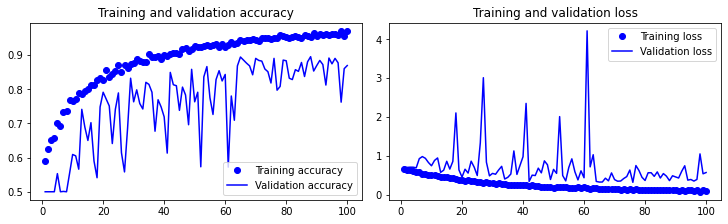

In [10]:
plot_history(history)

In [12]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.854


### Summary

- **Residual connections**: for stability;
- **Batch / Layer normalisation**: for stability;
- **Separable Depthwise Convolutions**: optimising convolutions;
- **Xception**: a vision model including these elements.